In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from fcn_dataset import CamVidDataset, rev_normalize

In [3]:
class_dict_path = "class_dict.csv"
resolution = (240, 240)
class_dict = pd.read_csv("CamVid/" + class_dict_path)

images_dir = "train/"
labels_dir = "train_labels/"
camvid_dataset = CamVidDataset(root='CamVid/', images_dir=images_dir, labels_dir=labels_dir, class_dict_path=class_dict_path, resolution=resolution)
train_loader = torch.utils.data.DataLoader(camvid_dataset, batch_size=4, shuffle=True, num_workers=4)

val_images_dir = "val/"
val_labels_dir = "val_labels/"
val_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=val_images_dir, labels_dir=val_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
val_loader = torch.utils.data.DataLoader(val_camvid_dataset, batch_size=4, shuffle=True, num_workers=4)

test_images_dir = "test/"
test_labels_dir = "test_labels/"
test_camvid_dataset = CamVidDataset(root='CamVid/', images_dir=test_images_dir, labels_dir=test_labels_dir, class_dict_path=class_dict_path, resolution=resolution)
test_loader = torch.utils.data.DataLoader(test_camvid_dataset, batch_size=4, shuffle=True, num_workers=4)

In [5]:
# Example of loading a single sample
image, label = camvid_dataset[0]
print(image.size())

# To visualize or further process, you might want to convert 'label' back to a color image or directly use it for training a segmentation model.
label_vis = label.numpy().astype(np.float32)
label_vis /= 31.
label_vis *= 255.
label_vis = label_vis.astype(np.uint8)
label_vis = Image.fromarray(label_vis)
image_vis = transforms.functional.to_pil_image(rev_normalize(image))

torch.Size([3, 240, 240])


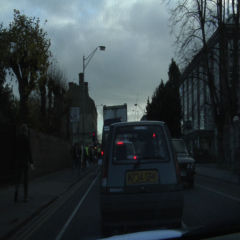

In [6]:
image_vis

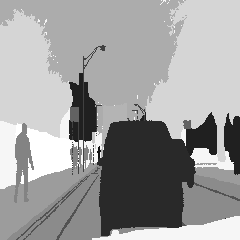

In [7]:
label_vis

In [8]:
from fcn_model import FCN8s
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = FCN8s(num_classes=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
num_classes = 32

/projectnb/cs585/sbit/.conda/envs/fcn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/projectnb/cs585/sbit/.conda/envs/fcn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Experimenting

In [ ]:
# Define the loss function and optimizer
def loss_fn(outputs, labels):
    """ 
    In the original paper, the authors mention a per-pixel multinomial logistic loss, which is equivalent to the standard cross-entropy loss.
    """ 
    return torch.nn.CrossEntropyLoss()(outputs, labels)

def calculate_metrics(pred, target, num_classes):
    """ 
    Calculate the pixel accuracy, mean IoU, and frequency weighted IoU.
    """
    total_wt = np.sum([(target == i).sum() for i in range(num_classes)])
    pixel_acc = (pred == target).sum() / (total_wt)
    iou = []
    for i in range(num_classes):
        intersection = ((pred == i) & (target == i)).sum()
        union = ((pred == i) | (target == i)).sum()
        # For a target image, one or more classes might not be in that image leading to zero union
        if union>0:
            iou.append(intersection / union)
        else:
            iou.append(0)

    mean_iou = np.mean(iou)
    freq_iou = np.sum([(target == i).sum() * iou[i] for i in range(num_classes)]) / (total_wt)
    return pixel_acc, mean_iou, freq_iou

In [ ]:
# Train the model
loss_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm.tqdm(train_loader)):
        images, labels = images.to("cpu"), labels.to("cpu")

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), sum(loss_list)/len(loss_list)))
            loss_list = []
            pixel_acc, mean_iou, freq_iou = calculate_metrics(torch.argmax(outputs, dim=1).cpu().numpy(), labels.cpu().numpy(), num_classes)
            print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}'.format(pixel_acc, mean_iou, freq_iou))

In [ ]:
id = 1
test = images[id].numpy()
test_lab = labels[id].numpy()
test = np.moveaxis(test, 0, -1)
test_lab = np.moveaxis(test_lab, 0, -1)

In [ ]:
plt.imshow(test)

In [ ]:
plt.imshow(test_lab)

In [ ]:
outputs = model(images)
outputs = torch.argmax(outputs, dim=1).cpu().numpy()

In [ ]:
plt.imshow(outputs[0])

#### Train function - main

In [9]:
# Define the loss function and optimizer
def loss_fn(outputs, labels):
    """ 
    In the original paper, the authors mention a per-pixel multinomial logistic loss, which is equivalent to the standard cross-entropy loss.
    """ 
    return torch.nn.CrossEntropyLoss()(outputs, labels)

def calculate_metrics(pred, target, num_classes):
    """ 
    Calculate the pixel accuracy, mean IoU, and frequency weighted IoU.
    """
    total_wt = np.sum([(target == i).sum() for i in range(num_classes)])
    pixel_acc = (pred == target).sum() / (total_wt)
    iou = []
    for i in range(num_classes):
        intersection = ((pred == i) & (target == i)).sum()
        union = ((pred == i) | (target == i)).sum()
        # For a target image, one or more classes might not be in that image leading to zero union
        if union>0:
            iou.append(intersection / union)
        else:
            iou.append(0)

    mean_iou = np.mean(iou)
    freq_iou = np.sum([(target == i).sum() * iou[i] for i in range(num_classes)]) / (total_wt)
    return pixel_acc, mean_iou, freq_iou

def eval_model(model, dataloader, device, save_pred=False):
    print("Starting eval ....")
    model.eval()
    loss_list = []
    if save_pred:
        pred_list = []
    with torch.no_grad():
        for images, labels in tqdm.tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            if save_pred:
                pred_list.append(predicted.cpu().numpy())
           
        loss = sum(loss_list) / len(loss_list)
        pixel_acc, mean_iou, freq_iou = calculate_metrics(predicted.cpu().numpy(), labels.cpu().numpy(), num_classes)
        print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}, Loss: {:.4f}'.format(pixel_acc, mean_iou, freq_iou, loss))

    if save_pred:
        pred_list = np.concatenate(pred_list, axis=0)
        np.save('test_pred.npy', pred_list)
    model.train()

    
# Train the model
loss_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(tqdm.tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), sum(loss_list)/len(loss_list)))
            loss_list = []
            pixel_acc, mean_iou, freq_iou = calculate_metrics(torch.argmax(outputs, dim=1).cpu().numpy(), labels.cpu().numpy(), num_classes)
            print('Pixel accuracy: {:.4f}, Mean IoU: {:.4f}, Frequency weighted IoU: {:.4f}'.format(pixel_acc, mean_iou, freq_iou))
    # eval the model
    eval_model(model, val_loader, device)

  0%|          | 0/93 [00:00<?, ?it/s]/projectnb/cs585/sbit/.conda/envs/fcn/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
 11%|█         | 10/93 [00:10<01:02,  1.34it/s]

Epoch [1/10], Step [10/93], Loss: 3.4324
Pixel accuracy: 0.4299, Mean IoU: 0.0296, Frequency weighted IoU: 0.2434


 22%|██▏       | 20/93 [00:16<00:40,  1.80it/s]

Epoch [1/10], Step [20/93], Loss: 1.6571
Pixel accuracy: 0.6361, Mean IoU: 0.0636, Frequency weighted IoU: 0.4453


 33%|███▎      | 31/93 [00:24<00:44,  1.38it/s]

Epoch [1/10], Step [30/93], Loss: 1.2958
Pixel accuracy: 0.5418, Mean IoU: 0.0556, Frequency weighted IoU: 0.3360


 43%|████▎     | 40/93 [00:29<00:29,  1.81it/s]

Epoch [1/10], Step [40/93], Loss: 1.2647
Pixel accuracy: 0.5696, Mean IoU: 0.0600, Frequency weighted IoU: 0.3688


 55%|█████▍    | 51/93 [00:37<00:30,  1.39it/s]

Epoch [1/10], Step [50/93], Loss: 1.1007
Pixel accuracy: 0.7215, Mean IoU: 0.0909, Frequency weighted IoU: 0.5559


 65%|██████▍   | 60/93 [00:43<00:18,  1.81it/s]

Epoch [1/10], Step [60/93], Loss: 1.0504
Pixel accuracy: 0.7198, Mean IoU: 0.0988, Frequency weighted IoU: 0.5575


 76%|███████▋  | 71/93 [00:50<00:15,  1.42it/s]

Epoch [1/10], Step [70/93], Loss: 1.0034
Pixel accuracy: 0.7359, Mean IoU: 0.0995, Frequency weighted IoU: 0.5715


 86%|████████▌ | 80/93 [00:56<00:07,  1.81it/s]

Epoch [1/10], Step [80/93], Loss: 1.0765
Pixel accuracy: 0.7440, Mean IoU: 0.1088, Frequency weighted IoU: 0.5964


 98%|█████████▊| 91/93 [01:03<00:01,  1.49it/s]

Epoch [1/10], Step [90/93], Loss: 1.0405
Pixel accuracy: 0.7016, Mean IoU: 0.1158, Frequency weighted IoU: 0.5268


100%|██████████| 93/93 [01:04<00:00,  1.45it/s]


Starting eval ....


100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Pixel accuracy: 0.7962, Mean IoU: 0.1165, Frequency weighted IoU: 0.6789, Loss: 0.8935


 12%|█▏        | 11/93 [00:08<00:45,  1.81it/s]

Epoch [2/10], Step [10/93], Loss: 0.8746
Pixel accuracy: 0.7619, Mean IoU: 0.1086, Frequency weighted IoU: 0.6053


 22%|██▏       | 20/93 [00:13<00:31,  2.32it/s]

Epoch [2/10], Step [20/93], Loss: 0.8317
Pixel accuracy: 0.7587, Mean IoU: 0.1320, Frequency weighted IoU: 0.6277


 33%|███▎      | 31/93 [00:21<00:33,  1.84it/s]

Epoch [2/10], Step [30/93], Loss: 0.7452
Pixel accuracy: 0.8076, Mean IoU: 0.1114, Frequency weighted IoU: 0.6688


 43%|████▎     | 40/93 [00:26<00:22,  2.34it/s]

Epoch [2/10], Step [40/93], Loss: 0.8278
Pixel accuracy: 0.7966, Mean IoU: 0.1380, Frequency weighted IoU: 0.6713


 55%|█████▍    | 51/93 [00:34<00:22,  1.85it/s]

Epoch [2/10], Step [50/93], Loss: 0.7782
Pixel accuracy: 0.7915, Mean IoU: 0.1482, Frequency weighted IoU: 0.6485


 65%|██████▍   | 60/93 [00:39<00:14,  2.33it/s]

Epoch [2/10], Step [60/93], Loss: 0.7508
Pixel accuracy: 0.7703, Mean IoU: 0.1253, Frequency weighted IoU: 0.6360


 76%|███████▋  | 71/93 [00:47<00:11,  1.85it/s]

Epoch [2/10], Step [70/93], Loss: 0.7544
Pixel accuracy: 0.7680, Mean IoU: 0.1270, Frequency weighted IoU: 0.6407


 86%|████████▌ | 80/93 [00:52<00:05,  2.34it/s]

Epoch [2/10], Step [80/93], Loss: 0.8274
Pixel accuracy: 0.8371, Mean IoU: 0.1621, Frequency weighted IoU: 0.7225


 98%|█████████▊| 91/93 [01:00<00:01,  1.84it/s]

Epoch [2/10], Step [90/93], Loss: 0.6927
Pixel accuracy: 0.8103, Mean IoU: 0.1648, Frequency weighted IoU: 0.6823


100%|██████████| 93/93 [01:00<00:00,  1.54it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.37it/s]


Pixel accuracy: 0.7608, Mean IoU: 0.1167, Frequency weighted IoU: 0.6440, Loss: 0.7681


 11%|█         | 10/93 [00:07<00:56,  1.47it/s]

Epoch [3/10], Step [10/93], Loss: 0.7752
Pixel accuracy: 0.7372, Mean IoU: 0.1343, Frequency weighted IoU: 0.5957


 22%|██▏       | 20/93 [00:13<00:34,  2.09it/s]

Epoch [3/10], Step [20/93], Loss: 0.7199
Pixel accuracy: 0.7764, Mean IoU: 0.1585, Frequency weighted IoU: 0.6483


 32%|███▏      | 30/93 [00:20<00:41,  1.50it/s]

Epoch [3/10], Step [30/93], Loss: 0.7867
Pixel accuracy: 0.7881, Mean IoU: 0.1679, Frequency weighted IoU: 0.6557


 43%|████▎     | 40/93 [00:26<00:25,  2.06it/s]

Epoch [3/10], Step [40/93], Loss: 0.6608
Pixel accuracy: 0.8203, Mean IoU: 0.1901, Frequency weighted IoU: 0.7006


 54%|█████▍    | 50/93 [00:33<00:28,  1.49it/s]

Epoch [3/10], Step [50/93], Loss: 0.6998
Pixel accuracy: 0.7895, Mean IoU: 0.1552, Frequency weighted IoU: 0.6597


 65%|██████▍   | 60/93 [00:39<00:16,  2.02it/s]

Epoch [3/10], Step [60/93], Loss: 0.6326
Pixel accuracy: 0.8647, Mean IoU: 0.1916, Frequency weighted IoU: 0.7675


 75%|███████▌  | 70/93 [00:46<00:15,  1.49it/s]

Epoch [3/10], Step [70/93], Loss: 0.6635
Pixel accuracy: 0.8256, Mean IoU: 0.1650, Frequency weighted IoU: 0.7083


 86%|████████▌ | 80/93 [00:52<00:06,  1.94it/s]

Epoch [3/10], Step [80/93], Loss: 0.6439
Pixel accuracy: 0.8073, Mean IoU: 0.1684, Frequency weighted IoU: 0.6902


 98%|█████████▊| 91/93 [00:59<00:01,  1.92it/s]

Epoch [3/10], Step [90/93], Loss: 0.6005
Pixel accuracy: 0.8720, Mean IoU: 0.2052, Frequency weighted IoU: 0.7774


100%|██████████| 93/93 [01:00<00:00,  1.54it/s]


Starting eval ....


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


Pixel accuracy: 0.8262, Mean IoU: 0.1612, Frequency weighted IoU: 0.7085, Loss: 0.6768


 11%|█         | 10/93 [00:07<00:55,  1.48it/s]

Epoch [4/10], Step [10/93], Loss: 0.6469
Pixel accuracy: 0.8643, Mean IoU: 0.1869, Frequency weighted IoU: 0.7691


 22%|██▏       | 20/93 [00:13<00:36,  1.99it/s]

Epoch [4/10], Step [20/93], Loss: 0.5368
Pixel accuracy: 0.8113, Mean IoU: 0.1797, Frequency weighted IoU: 0.6900


 32%|███▏      | 30/93 [00:20<00:39,  1.58it/s]

Epoch [4/10], Step [30/93], Loss: 0.6733
Pixel accuracy: 0.7981, Mean IoU: 0.1634, Frequency weighted IoU: 0.6835


 43%|████▎     | 40/93 [00:26<00:27,  1.90it/s]

Epoch [4/10], Step [40/93], Loss: 0.5955
Pixel accuracy: 0.8000, Mean IoU: 0.1613, Frequency weighted IoU: 0.6665


 54%|█████▍    | 50/93 [00:33<00:25,  1.67it/s]

Epoch [4/10], Step [50/93], Loss: 0.6013
Pixel accuracy: 0.8479, Mean IoU: 0.1409, Frequency weighted IoU: 0.7390


 65%|██████▍   | 60/93 [00:39<00:18,  1.78it/s]

Epoch [4/10], Step [60/93], Loss: 0.5493
Pixel accuracy: 0.7704, Mean IoU: 0.1595, Frequency weighted IoU: 0.6365


 75%|███████▌  | 70/93 [00:46<00:12,  1.78it/s]

Epoch [4/10], Step [70/93], Loss: 0.5824
Pixel accuracy: 0.8049, Mean IoU: 0.1910, Frequency weighted IoU: 0.6926


 86%|████████▌ | 80/93 [00:52<00:07,  1.67it/s]

Epoch [4/10], Step [80/93], Loss: 0.5528
Pixel accuracy: 0.7876, Mean IoU: 0.1684, Frequency weighted IoU: 0.6661


 97%|█████████▋| 90/93 [00:59<00:01,  1.93it/s]

Epoch [4/10], Step [90/93], Loss: 0.7015
Pixel accuracy: 0.8251, Mean IoU: 0.1547, Frequency weighted IoU: 0.7188


100%|██████████| 93/93 [01:00<00:00,  1.53it/s]


Starting eval ....


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Pixel accuracy: 0.8356, Mean IoU: 0.1996, Frequency weighted IoU: 0.7260, Loss: 0.5847


 12%|█▏        | 11/93 [00:08<00:45,  1.80it/s]

Epoch [5/10], Step [10/93], Loss: 0.6021
Pixel accuracy: 0.8397, Mean IoU: 0.2206, Frequency weighted IoU: 0.7283


 22%|██▏       | 20/93 [00:13<00:32,  2.27it/s]

Epoch [5/10], Step [20/93], Loss: 0.5573
Pixel accuracy: 0.8003, Mean IoU: 0.1687, Frequency weighted IoU: 0.6800


 33%|███▎      | 31/93 [00:21<00:34,  1.78it/s]

Epoch [5/10], Step [30/93], Loss: 0.5522
Pixel accuracy: 0.8322, Mean IoU: 0.1927, Frequency weighted IoU: 0.7270


 43%|████▎     | 40/93 [00:27<00:23,  2.27it/s]

Epoch [5/10], Step [40/93], Loss: 0.5151
Pixel accuracy: 0.8443, Mean IoU: 0.1653, Frequency weighted IoU: 0.7439


 55%|█████▍    | 51/93 [00:35<00:23,  1.79it/s]

Epoch [5/10], Step [50/93], Loss: 0.5156
Pixel accuracy: 0.8363, Mean IoU: 0.1888, Frequency weighted IoU: 0.7276


 65%|██████▍   | 60/93 [00:40<00:14,  2.26it/s]

Epoch [5/10], Step [60/93], Loss: 0.4618
Pixel accuracy: 0.8654, Mean IoU: 0.2040, Frequency weighted IoU: 0.7728


 76%|███████▋  | 71/93 [00:48<00:12,  1.78it/s]

Epoch [5/10], Step [70/93], Loss: 0.5838
Pixel accuracy: 0.8624, Mean IoU: 0.2476, Frequency weighted IoU: 0.7736


 86%|████████▌ | 80/93 [00:54<00:05,  2.25it/s]

Epoch [5/10], Step [80/93], Loss: 0.5828
Pixel accuracy: 0.7669, Mean IoU: 0.1605, Frequency weighted IoU: 0.6474


 98%|█████████▊| 91/93 [01:01<00:01,  1.79it/s]

Epoch [5/10], Step [90/93], Loss: 0.5738
Pixel accuracy: 0.7920, Mean IoU: 0.1725, Frequency weighted IoU: 0.6723


100%|██████████| 93/93 [01:02<00:00,  1.49it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.36it/s]


Pixel accuracy: 0.8140, Mean IoU: 0.1683, Frequency weighted IoU: 0.6938, Loss: 0.6515


 11%|█         | 10/93 [00:07<00:56,  1.47it/s]

Epoch [6/10], Step [10/93], Loss: 0.5655
Pixel accuracy: 0.8363, Mean IoU: 0.2014, Frequency weighted IoU: 0.7290


 22%|██▏       | 20/93 [00:13<00:36,  2.01it/s]

Epoch [6/10], Step [20/93], Loss: 0.4961
Pixel accuracy: 0.8546, Mean IoU: 0.2262, Frequency weighted IoU: 0.7583


 32%|███▏      | 30/93 [00:20<00:40,  1.54it/s]

Epoch [6/10], Step [30/93], Loss: 0.5139
Pixel accuracy: 0.8215, Mean IoU: 0.2167, Frequency weighted IoU: 0.7298


 43%|████▎     | 40/93 [00:26<00:28,  1.84it/s]

Epoch [6/10], Step [40/93], Loss: 0.4707
Pixel accuracy: 0.8338, Mean IoU: 0.1701, Frequency weighted IoU: 0.7217


 54%|█████▍    | 50/93 [00:33<00:24,  1.72it/s]

Epoch [6/10], Step [50/93], Loss: 0.5216
Pixel accuracy: 0.8481, Mean IoU: 0.2391, Frequency weighted IoU: 0.7470


 65%|██████▍   | 60/93 [00:40<00:20,  1.62it/s]

Epoch [6/10], Step [60/93], Loss: 0.7043
Pixel accuracy: 0.8029, Mean IoU: 0.1521, Frequency weighted IoU: 0.6805


 75%|███████▌  | 70/93 [00:46<00:11,  1.96it/s]

Epoch [6/10], Step [70/93], Loss: 0.7671
Pixel accuracy: 0.8413, Mean IoU: 0.1915, Frequency weighted IoU: 0.7403


 87%|████████▋ | 81/93 [00:53<00:06,  1.74it/s]

Epoch [6/10], Step [80/93], Loss: 0.6591
Pixel accuracy: 0.8231, Mean IoU: 0.2308, Frequency weighted IoU: 0.7133


 97%|█████████▋| 90/93 [00:59<00:01,  2.21it/s]

Epoch [6/10], Step [90/93], Loss: 0.5747
Pixel accuracy: 0.8516, Mean IoU: 0.1726, Frequency weighted IoU: 0.7537


100%|██████████| 93/93 [01:01<00:00,  1.51it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


Pixel accuracy: 0.8426, Mean IoU: 0.2045, Frequency weighted IoU: 0.7314, Loss: 0.6467


 12%|█▏        | 11/93 [00:08<00:45,  1.79it/s]

Epoch [7/10], Step [10/93], Loss: 0.5743
Pixel accuracy: 0.8345, Mean IoU: 0.2325, Frequency weighted IoU: 0.7215


 22%|██▏       | 20/93 [00:13<00:31,  2.32it/s]

Epoch [7/10], Step [20/93], Loss: 0.5223
Pixel accuracy: 0.8442, Mean IoU: 0.2027, Frequency weighted IoU: 0.7422


 33%|███▎      | 31/93 [00:21<00:33,  1.84it/s]

Epoch [7/10], Step [30/93], Loss: 0.5328
Pixel accuracy: 0.8305, Mean IoU: 0.1981, Frequency weighted IoU: 0.7294


 43%|████▎     | 40/93 [00:26<00:22,  2.33it/s]

Epoch [7/10], Step [40/93], Loss: 0.4821
Pixel accuracy: 0.8536, Mean IoU: 0.2512, Frequency weighted IoU: 0.7540


 55%|█████▍    | 51/93 [00:34<00:23,  1.79it/s]

Epoch [7/10], Step [50/93], Loss: 0.4779
Pixel accuracy: 0.8490, Mean IoU: 0.2507, Frequency weighted IoU: 0.7500


 65%|██████▍   | 60/93 [00:40<00:14,  2.26it/s]

Epoch [7/10], Step [60/93], Loss: 0.4808
Pixel accuracy: 0.8594, Mean IoU: 0.2695, Frequency weighted IoU: 0.7597


 76%|███████▋  | 71/93 [00:47<00:11,  1.85it/s]

Epoch [7/10], Step [70/93], Loss: 0.5414
Pixel accuracy: 0.8058, Mean IoU: 0.2386, Frequency weighted IoU: 0.6847


 86%|████████▌ | 80/93 [00:53<00:05,  2.34it/s]

Epoch [7/10], Step [80/93], Loss: 0.4716
Pixel accuracy: 0.8682, Mean IoU: 0.2362, Frequency weighted IoU: 0.7755


 98%|█████████▊| 91/93 [01:00<00:01,  1.88it/s]

Epoch [7/10], Step [90/93], Loss: 0.5337
Pixel accuracy: 0.8033, Mean IoU: 0.2280, Frequency weighted IoU: 0.6846


100%|██████████| 93/93 [01:00<00:00,  1.53it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


Pixel accuracy: 0.8411, Mean IoU: 0.2904, Frequency weighted IoU: 0.7364, Loss: 0.5451


 12%|█▏        | 11/93 [00:08<00:46,  1.77it/s]

Epoch [8/10], Step [10/93], Loss: 0.4863
Pixel accuracy: 0.8631, Mean IoU: 0.2310, Frequency weighted IoU: 0.7698


 22%|██▏       | 20/93 [00:13<00:31,  2.35it/s]

Epoch [8/10], Step [20/93], Loss: 0.4633
Pixel accuracy: 0.8492, Mean IoU: 0.2252, Frequency weighted IoU: 0.7458


 33%|███▎      | 31/93 [00:21<00:33,  1.85it/s]

Epoch [8/10], Step [30/93], Loss: 0.4926
Pixel accuracy: 0.8378, Mean IoU: 0.2246, Frequency weighted IoU: 0.7286


 43%|████▎     | 40/93 [00:26<00:22,  2.34it/s]

Epoch [8/10], Step [40/93], Loss: 0.4629
Pixel accuracy: 0.8428, Mean IoU: 0.2018, Frequency weighted IoU: 0.7390


 55%|█████▍    | 51/93 [00:34<00:22,  1.86it/s]

Epoch [8/10], Step [50/93], Loss: 0.4367
Pixel accuracy: 0.8572, Mean IoU: 0.2287, Frequency weighted IoU: 0.7586


 65%|██████▍   | 60/93 [00:39<00:14,  2.32it/s]

Epoch [8/10], Step [60/93], Loss: 0.4106
Pixel accuracy: 0.8770, Mean IoU: 0.2583, Frequency weighted IoU: 0.7886


 75%|███████▌  | 70/93 [00:46<00:16,  1.43it/s]

Epoch [8/10], Step [70/93], Loss: 0.4888
Pixel accuracy: 0.8759, Mean IoU: 0.3541, Frequency weighted IoU: 0.7926


 86%|████████▌ | 80/93 [00:52<00:05,  2.35it/s]

Epoch [8/10], Step [80/93], Loss: 0.4492
Pixel accuracy: 0.8454, Mean IoU: 0.2557, Frequency weighted IoU: 0.7462


 98%|█████████▊| 91/93 [01:00<00:01,  1.85it/s]

Epoch [8/10], Step [90/93], Loss: 0.4576
Pixel accuracy: 0.8557, Mean IoU: 0.2438, Frequency weighted IoU: 0.7654


100%|██████████| 93/93 [01:00<00:00,  1.54it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


Pixel accuracy: 0.8836, Mean IoU: 0.2950, Frequency weighted IoU: 0.7957, Loss: 0.4961


 12%|█▏        | 11/93 [00:08<00:46,  1.77it/s]

Epoch [9/10], Step [10/93], Loss: 0.4530
Pixel accuracy: 0.8550, Mean IoU: 0.2671, Frequency weighted IoU: 0.7478


 22%|██▏       | 20/93 [00:13<00:32,  2.28it/s]

Epoch [9/10], Step [20/93], Loss: 0.4113
Pixel accuracy: 0.8925, Mean IoU: 0.2865, Frequency weighted IoU: 0.8102


 33%|███▎      | 31/93 [00:21<00:34,  1.79it/s]

Epoch [9/10], Step [30/93], Loss: 0.4342
Pixel accuracy: 0.8490, Mean IoU: 0.2314, Frequency weighted IoU: 0.7460


 43%|████▎     | 40/93 [00:27<00:23,  2.27it/s]

Epoch [9/10], Step [40/93], Loss: 0.4387
Pixel accuracy: 0.8712, Mean IoU: 0.2057, Frequency weighted IoU: 0.7938


 55%|█████▍    | 51/93 [00:35<00:23,  1.80it/s]

Epoch [9/10], Step [50/93], Loss: 0.4376
Pixel accuracy: 0.9027, Mean IoU: 0.2549, Frequency weighted IoU: 0.8363


 65%|██████▍   | 60/93 [00:40<00:14,  2.28it/s]

Epoch [9/10], Step [60/93], Loss: 0.4345
Pixel accuracy: 0.8516, Mean IoU: 0.2565, Frequency weighted IoU: 0.7529


 76%|███████▋  | 71/93 [00:48<00:12,  1.79it/s]

Epoch [9/10], Step [70/93], Loss: 0.4164
Pixel accuracy: 0.8164, Mean IoU: 0.2351, Frequency weighted IoU: 0.6928


 86%|████████▌ | 80/93 [00:53<00:05,  2.33it/s]

Epoch [9/10], Step [80/93], Loss: 0.4294
Pixel accuracy: 0.8344, Mean IoU: 0.2502, Frequency weighted IoU: 0.7254


 98%|█████████▊| 91/93 [01:01<00:01,  1.88it/s]

Epoch [9/10], Step [90/93], Loss: 0.4224
Pixel accuracy: 0.9057, Mean IoU: 0.3123, Frequency weighted IoU: 0.8335


100%|██████████| 93/93 [01:01<00:00,  1.51it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.38it/s]


Pixel accuracy: 0.8422, Mean IoU: 0.2310, Frequency weighted IoU: 0.7325, Loss: 0.4801


 12%|█▏        | 11/93 [00:08<00:45,  1.79it/s]

Epoch [10/10], Step [10/93], Loss: 0.4175
Pixel accuracy: 0.9097, Mean IoU: 0.2968, Frequency weighted IoU: 0.8434


 22%|██▏       | 20/93 [00:13<00:31,  2.35it/s]

Epoch [10/10], Step [20/93], Loss: 0.4219
Pixel accuracy: 0.8354, Mean IoU: 0.2222, Frequency weighted IoU: 0.7366


 33%|███▎      | 31/93 [00:21<00:33,  1.84it/s]

Epoch [10/10], Step [30/93], Loss: 0.4325
Pixel accuracy: 0.8799, Mean IoU: 0.3126, Frequency weighted IoU: 0.7976


 43%|████▎     | 40/93 [00:26<00:22,  2.33it/s]

Epoch [10/10], Step [40/93], Loss: 0.4302
Pixel accuracy: 0.8640, Mean IoU: 0.2961, Frequency weighted IoU: 0.7723


 55%|█████▍    | 51/93 [00:34<00:22,  1.84it/s]

Epoch [10/10], Step [50/93], Loss: 0.4207
Pixel accuracy: 0.9227, Mean IoU: 0.2521, Frequency weighted IoU: 0.8632


 65%|██████▍   | 60/93 [00:39<00:14,  2.34it/s]

Epoch [10/10], Step [60/93], Loss: 0.3975
Pixel accuracy: 0.8681, Mean IoU: 0.2774, Frequency weighted IoU: 0.7808


 76%|███████▋  | 71/93 [00:47<00:11,  1.85it/s]

Epoch [10/10], Step [70/93], Loss: 0.4412
Pixel accuracy: 0.8997, Mean IoU: 0.3096, Frequency weighted IoU: 0.8304


 86%|████████▌ | 80/93 [00:52<00:05,  2.34it/s]

Epoch [10/10], Step [80/93], Loss: 0.4203
Pixel accuracy: 0.8569, Mean IoU: 0.2767, Frequency weighted IoU: 0.7534


 98%|█████████▊| 91/93 [01:00<00:01,  1.86it/s]

Epoch [10/10], Step [90/93], Loss: 0.3460
Pixel accuracy: 0.8923, Mean IoU: 0.2046, Frequency weighted IoU: 0.8255


100%|██████████| 93/93 [01:00<00:00,  1.54it/s]


Starting eval ....


100%|██████████| 25/25 [00:18<00:00,  1.38it/s]

Pixel accuracy: 0.8805, Mean IoU: 0.3058, Frequency weighted IoU: 0.8039, Loss: 0.4824


In [11]:
eval_model(model, test_loader, device)

Starting eval ....


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]

Pixel accuracy: 0.8456, Mean IoU: 0.2329, Frequency weighted IoU: 0.7566, Loss: 0.6020
